In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import cv2

PATH_AUGMENT = "/home/mariopasc/Python/Datasets/Coronario_Patient/CADICA_Augmented_Images"

In [101]:
file = "processed_train.csv"
path = os.path.join(PATH_AUGMENT, file)

df = pd.read_csv(path)
elastic = df[df["Frame_path"].str.contains("elastic")]

series = elastic.iloc[1, :]
base = str(os.path.basename(series["Frame_path"])).split("_")
base = base[0] + "_" + base[1] + "_" + base[2] + ".png"

original_image = df[df["Frame_path"].str.contains(base)]

elastic

,LesionLabel,Frame_path,Groundtruth_path
2704,p50_70,/home/mariopasc/Python/Datasets/Coronario_Pati...,/home/mariopasc/Python/Datasets/Coronario_Pati...
2709,p50_70,/home/mariopasc/Python/Datasets/Coronario_Pati...,/home/mariopasc/Python/Datasets/Coronario_Pati...
2710,p50_70,/home/mariopasc/Python/Datasets/Coronario_Pati...,/home/mariopasc/Python/Datasets/Coronario_Pati...
2711,p50_70,/home/mariopasc/Python/Datasets/Coronario_Pati...,/home/mariopasc/Python/Datasets/Coronario_Pati...
2713,p50_70,/home/mariopasc/Python/Datasets/Coronario_Pati...,/home/mariopasc/Python/Datasets/Coronario_Pati...
...,...,...,...
4103,nolesion,/home/mariopasc/Python/Datasets/Coronario_Pati...,nolesion
4104,nolesion,/home/mariopasc/Python/Datasets/Coronario_Pati...,nolesion
4106,nolesion,/home/mariopasc/Python/Datasets/Coronario_Pati...,nolesion
4124,nolesion,/home/mariopasc/Python/Datasets/Coronario_Pati...,nolesion


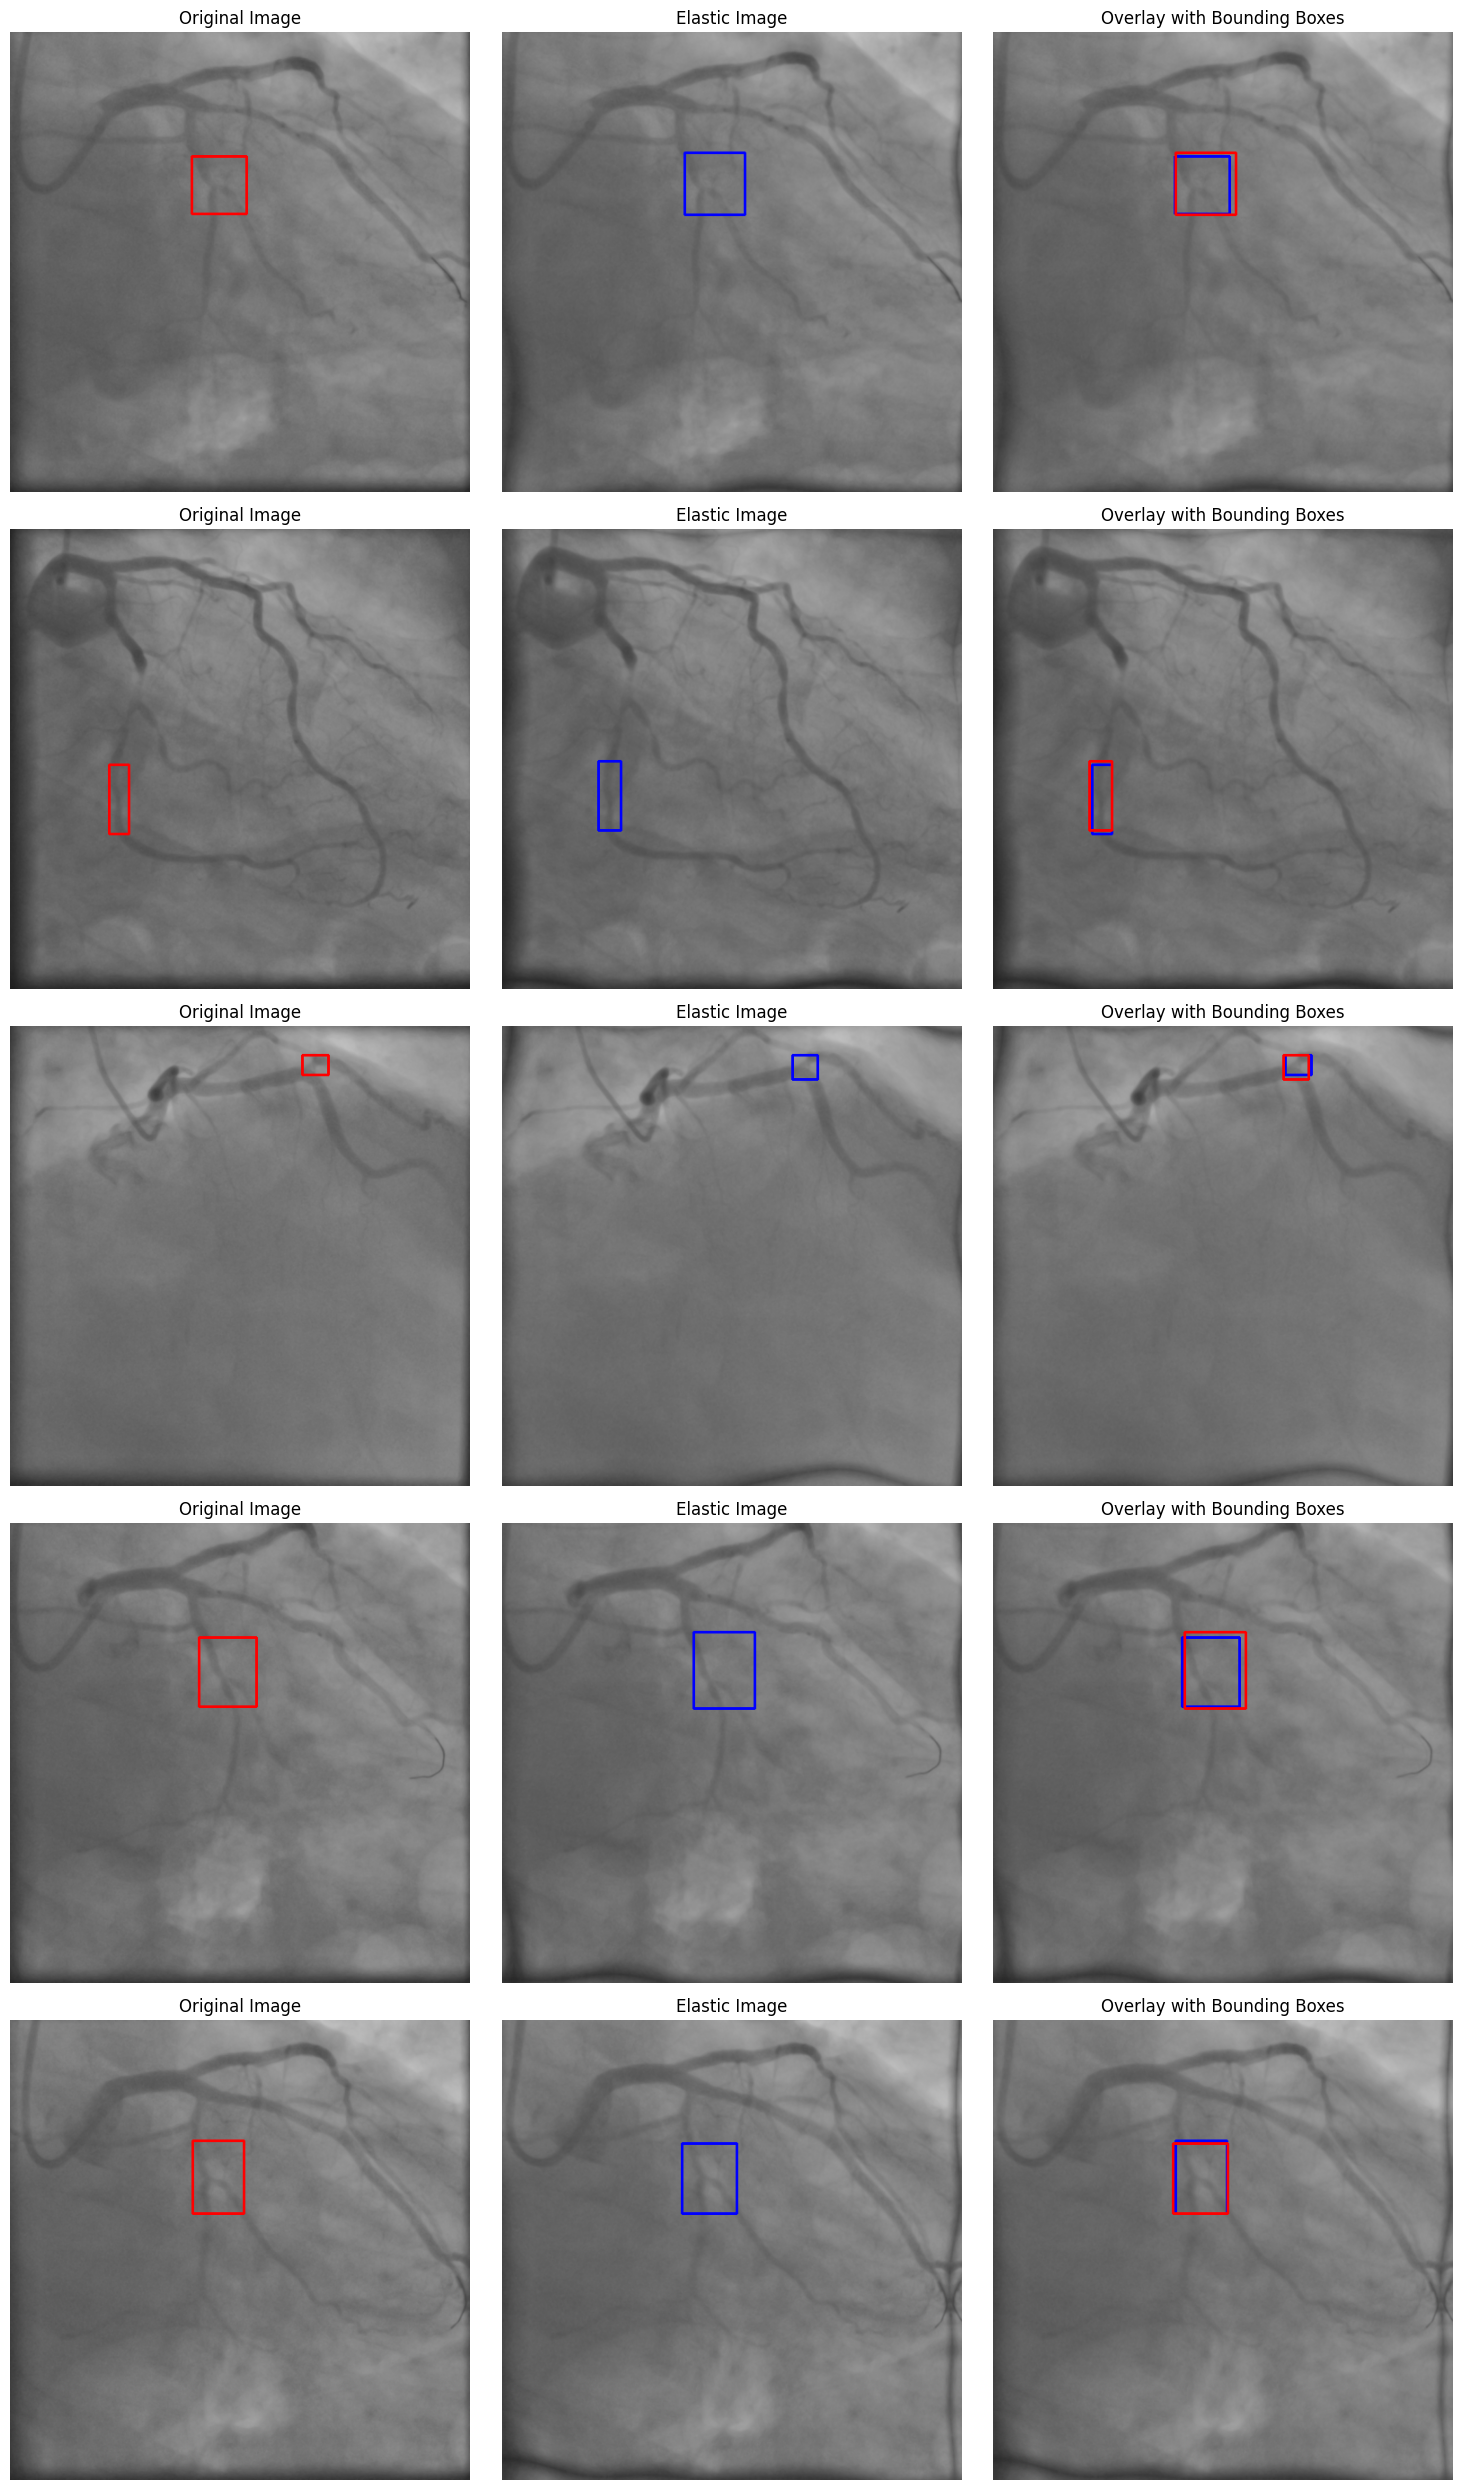

In [103]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
file = "processed_train.csv"
path = os.path.join(PATH_AUGMENT, file)
df = pd.read_csv(path)

# Filter for elastic images and get corresponding original images
elastic_images = df[df["Frame_path"].str.contains("elastic")].head(5)

# Helper function to load and draw bounding boxes on images
def load_and_draw_bounding_box(image_path, groundtruth_path, color, thickness=2):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Read the bounding box from the text file
    with open(groundtruth_path, 'r') as file:
        line = file.readline().strip()
        parts = line.split()
        x, y, w, h = map(int, parts[:4])  # Extract the bounding box values

    # Calculate the bottom-right corner of the bounding box
    x_max = x + w
    y_max = y + h

    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x_max, y_max), color, thickness)

    # Convert the image from BGR to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# Create a figure with enough subplots for all image pairs
num_images = len(elastic_images)
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

for index, (_, series) in enumerate(elastic_images.iterrows()):
    # Construct the base name to find the original image
    base = str(os.path.basename(series["Frame_path"])).split("_")
    base = base[0] + "_" + base[1] + "_" + base[2] + ".png"

    # Find the original image
    original_series = df[df["Frame_path"].str.contains(base)].iloc[0, :]

    # Load and draw bounding boxes for both images
    original_image_rgb = load_and_draw_bounding_box(
        original_series["Frame_path"], original_series["Groundtruth_path"], (0, 0, 255)
    )
    elastic_image_rgb = load_and_draw_bounding_box(
        series["Frame_path"], series["Groundtruth_path"], (255, 0, 0)
    )

    # Overlay both images with alpha blending
    blended_image = cv2.addWeighted(original_image_rgb, 0.1, elastic_image_rgb, 0.9, 0)

    # Draw both bounding boxes on the blended image
    with open(original_series["Groundtruth_path"], 'r') as file:
        x, y, w, h = map(int, file.readline().strip().split()[:4])
        cv2.rectangle(blended_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    with open(series["Groundtruth_path"], 'r') as file:
        x, y, w, h = map(int, file.readline().strip().split()[:4])
        cv2.rectangle(blended_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Plot images in the corresponding subplot
    axes[index, 0].imshow(original_image_rgb)
    axes[index, 0].axis("off")
    axes[index, 0].set_title("Original Image")

    axes[index, 1].imshow(elastic_image_rgb)
    axes[index, 1].axis("off")
    axes[index, 1].set_title("Elastic Image")

    axes[index, 2].imshow(blended_image)
    axes[index, 2].axis("off")
    axes[index, 2].set_title("Overlay with Bounding Boxes")

plt.tight_layout()
plt.savefig("./image.svg")
plt.show()